<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Manoj/diabetes_Prediction_CNN_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics as keras_metrics
import joblib
import os



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
drive_dir = '/content/drive/MyDrive/DiabetesPrediction/outputs'
model_dir = os.path.join(drive_dir, 'models')
os.makedirs(model_dir, exist_ok=True)


In [4]:
print("Loading preprocessed data...")
train_df = pd.read_csv(os.path.join(drive_dir, "clean_data_train.csv"))
test_df = pd.read_csv(os.path.join(drive_dir, "clean_data_test.csv"))


Loading preprocessed data...


In [5]:
X_train = train_df.drop('diabetes', axis=1).values
y_train = train_df['diabetes'].values

X_test = test_df.drop('diabetes', axis=1).values
y_test = test_df['diabetes'].values

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in training: {np.bincount(y_train)}")

Training set shape: (140262, 8)
Test set shape: (35066, 8)
Class distribution in training: [70131 70131]


In [6]:

#RESHAPE DATA FOR CNN

# CNN expects 3D input: (samples, features, channels)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nReshaped training data: {X_train_cnn.shape}")
print(f"Reshaped test data: {X_test_cnn.shape}")


Reshaped training data: (140262, 8, 1)
Reshaped test data: (35066, 8, 1)


In [7]:

# BUILD CNN MODEL

from tensorflow.keras import layers, models

def build_cnn_model(input_shape):
    """
    Build a 1D CNN model for diabetes prediction
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                      padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Second Convolutional Block
        layers.Conv1D(filters=128, kernel_size=3, activation='relu',
                      padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Third Convolutional Block
        layers.Conv1D(filters=256, kernel_size=3, activation='relu',
                      padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        # Global Average Pooling
        layers.GlobalAveragePooling1D(),

        # Dense Layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Build the model
input_shape = (X_train_cnn.shape[1], 1)
model = build_cnn_model(input_shape)

# Display model architecture
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,297 (653.50 KB)

 Trainable params: 166,017 (648.50 KB)

 Non-trainable params: 1,280 (5.00 KB)

In [8]:

# COMPILE MODEL

from tensorflow import keras

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [9]:

# DEFINE CALLBACKS

callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_cnn_model.h5'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

In [10]:

# TRAIN MODEL

print("\n" + "="*50)
print("Starting Model Training...")
print("="*50 + "\n")

history = model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Starting Model Training...

Epoch 1/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8483 - auc: 0.9304 - loss: 0.3342 - precision: 0.8460 - recall: 0.8513
Epoch 1: val_auc improved from -inf to 0.97419, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.8483 - auc: 0.9304 - loss: 0.3341 - precision: 0.8460 - recall: 0.8513 - val_accuracy: 0.9043 - val_auc: 0.9742 - val_loss: 0.2020 - val_precision: 0.8919 - val_recall: 0.9199 - learning_rate: 0.0010
Epoch 2/30
1742/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8907 - auc: 0.9661 - loss: 0.2320 - precision: 0.8820 - recall: 0.9018
Epoch 2: val_auc improved from 0.97419 to 0.97576, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8907 - auc: 0.9661 - loss: 0.2320 - precision: 0.8820 - recall: 0.9018 - val_accuracy: 0.9059 - val_auc: 0.9758 - val_loss: 0.1967 - val_precision: 0.8724 - val_recall: 0.9508 - learning_rate: 0.0010
Epoch 3/30
1747/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8942 - auc: 0.9682 - loss: 0.2237 - precision: 0.8839 - recall: 0.9075
Epoch 3: val_auc improved from 0.97576 to 0.97725, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8942 - auc: 0.9682 - loss: 0.2237 - precision: 0.8839 - recall: 0.9075 - val_accuracy: 0.9086 - val_auc: 0.9772 - val_loss: 0.1887 - val_precision: 0.8972 - val_recall: 0.9228 - learning_rate: 0.0010
Epoch 4/30
1750/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8948 - auc: 0.9698 - loss: 0.2165 - precision: 0.8858 - recall: 0.9067
Epoch 4: val_auc improved from 0.97725 to 0.97737, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8948 - auc: 0.9698 - loss: 0.2165 - precision: 0.8858 - recall: 0.9067 - val_accuracy: 0.9088 - val_auc: 0.9774 - val_loss: 0.1872 - val_precision: 0.8968 - val_recall: 0.9238 - learning_rate: 0.0010
Epoch 5/30
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9015 - auc: 0.9722 - loss: 0.2082 - precision: 0.8923 - recall: 0.9131
Epoch 5: val_auc improved from 0.97737 to 0.97755, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9015 - auc: 0.9722 - loss: 0.2082 - precision: 0.8923 - recall: 0.9131 - val_accuracy: 0.9098 - val_auc: 0.9775 - val_loss: 0.1891 - val_precision: 0.9055 - val_recall: 0.9151 - learning_rate: 0.0010
Epoch 6/30
1741/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9025 - auc: 0.9733 - loss: 0.2025 - precision: 0.8919 - recall: 0.9148
Epoch 6: val_auc improved from 0.97755 to 0.97875, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9025 - auc: 0.9733 - loss: 0.2025 - precision: 0.8919 - recall: 0.9147 - val_accuracy: 0.9122 - val_auc: 0.9787 - val_loss: 0.1799 - val_precision: 0.8958 - val_recall: 0.9328 - learning_rate: 0.0010
Epoch 7/30
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9022 - auc: 0.9738 - loss: 0.2005 - precision: 0.8925 - recall: 0.9135
Epoch 7: val_auc did not improve from 0.97875
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9022 - auc: 0.9738 - loss: 0.2005 - precision: 0.8925 - recall: 0.9135 - val_accuracy: 0.9114 - val_auc: 0.9785 - val_loss: 0.1810 - val_precision: 0.8917 - val_recall: 0.9365 - learning_rate: 0.0010
Epoch 8/30
1749/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9016 - auc: 0.9736 - loss: 0.2009 - precision: 0.8898 - recall: 0.9171
Epoch 8: val_auc improved from 0.97875 to 0.97879, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9016 - auc: 0.9736 - loss: 0.2009 - precision: 0.8898 - recall: 0.9171 - val_accuracy: 0.9125 - val_auc: 0.9788 - val_loss: 0.1790 - val_precision: 0.8910 - val_recall: 0.9399 - learning_rate: 0.0010
Epoch 9/30
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9059 - auc: 0.9747 - loss: 0.1967 - precision: 0.8944 - recall: 0.9198
Epoch 9: val_auc improved from 0.97879 to 0.97903, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9059 - auc: 0.9747 - loss: 0.1967 - precision: 0.8944 - recall: 0.9198 - val_accuracy: 0.9115 - val_auc: 0.9790 - val_loss: 0.1798 - val_precision: 0.8914 - val_recall: 0.9372 - learning_rate: 0.0010
Epoch 10/30
1744/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9054 - auc: 0.9750 - loss: 0.1956 - precision: 0.8954 - recall: 0.9179
Epoch 10: val_auc did not improve from 0.97903
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9054 - auc: 0.9750 - loss: 0.1956 - precision: 0.8954 - recall: 0.9179 - val_accuracy: 0.9108 - val_auc: 0.9788 - val_loss: 0.1805 - val_precision: 0.9174 - val_recall: 0.9028 - learning_rate: 0.0010
Epoch 11/30
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9055 - auc: 0.9754 - loss: 0.1935 - precision: 0.8967 - recall: 0.9163
Epoch 11: val_auc improved from 0.97903 to 0.97933, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9055 - auc: 0.9754 - loss: 0.1935 - precision: 0.8967 - recall: 0.9163 - val_accuracy: 0.9127 - val_auc: 0.9793 - val_loss: 0.1791 - val_precision: 0.8873 - val_recall: 0.9454 - learning_rate: 0.0010
Epoch 12/30
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9061 - auc: 0.9757 - loss: 0.1924 - precision: 0.8959 - recall: 0.9188
Epoch 12: val_auc did not improve from 0.97933
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9061 - auc: 0.9757 - loss: 0.1924 - precision: 0.8959 - recall: 0.9188 - val_accuracy: 0.9099 - val_auc: 0.9784 - val_loss: 0.1816 - val_precision: 0.9041 - val_recall: 0.9170 - learning_rate: 0.0010
Epoch 13/30
1749/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9061 - auc: 0.9755 - loss: 0.1928 - precision: 0.8960 - recall: 0.9197
Epoch 13: val_auc did not improve from 0.97933
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9061 - auc: 0.9755 - loss: 0.1928 - precision: 0.8960 

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9040 - auc: 0.9752 - loss: 0.1934 - precision: 0.8940 - recall: 0.9170 - val_accuracy: 0.9116 - val_auc: 0.9794 - val_loss: 0.1759 - val_precision: 0.8999 - val_recall: 0.9262 - learning_rate: 0.0010
Epoch 15/30
1743/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9046 - auc: 0.9758 - loss: 0.1908 - precision: 0.8964 - recall: 0.9158
Epoch 15: val_auc improved from 0.97936 to 0.97950, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9046 - auc: 0.9758 - loss: 0.1908 - precision: 0.8964 - recall: 0.9158 - val_accuracy: 0.9128 - val_auc: 0.9795 - val_loss: 0.1769 - val_precision: 0.9004 - val_recall: 0.9283 - learning_rate: 0.0010
Epoch 16/30
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9087 - auc: 0.9763 - loss: 0.1899 - precision: 0.8972 - recall: 0.9237
Epoch 16: val_auc did not improve from 0.97950
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9087 - auc: 0.9763 - loss: 0.1899 - precision: 0.8972 - recall: 0.9237 - val_accuracy: 0.9123 - val_auc: 0.9794 - val_loss: 0.1759 - val_precision: 0.9002 - val_recall: 0.9273 - learning_rate: 0.0010
Epoch 17/30
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9074 - auc: 0.9759 - loss: 0.1913 - precision: 0.8962 - recall: 0.9211
Epoch 17: val_auc improved from 0.97950 to 0.97959, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9074 - auc: 0.9759 - loss: 0.1913 - precision: 0.8962 - recall: 0.9211 - val_accuracy: 0.9123 - val_auc: 0.9796 - val_loss: 0.1770 - val_precision: 0.8801 - val_recall: 0.9546 - learning_rate: 0.0010
Epoch 18/30
1745/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9069 - auc: 0.9761 - loss: 0.1900 - precision: 0.8945 - recall: 0.9230
Epoch 18: val_auc improved from 0.97959 to 0.97987, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9069 - auc: 0.9761 - loss: 0.1900 - precision: 0.8946 - recall: 0.9230 - val_accuracy: 0.9131 - val_auc: 0.9799 - val_loss: 0.1752 - val_precision: 0.8905 - val_recall: 0.9418 - learning_rate: 0.0010
Epoch 19/30
1750/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9079 - auc: 0.9765 - loss: 0.1886 - precision: 0.8970 - recall: 0.9219
Epoch 19: val_auc did not improve from 0.97987
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9079 - auc: 0.9765 - loss: 0.1886 - precision: 0.8970 - recall: 0.9219 - val_accuracy: 0.9132 - val_auc: 0.9795 - val_loss: 0.1767 - val_precision: 0.9033 - val_recall: 0.9254 - learning_rate: 0.0010
Epoch 20/30
1746/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9088 - auc: 0.9765 - loss: 0.1885 - precision: 0.8994 - recall: 0.9206
Epoch 20: val_auc did not improve from 0.97987
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9088 - auc: 0.9765 - loss: 0.1885 - precision: 0.8993 

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9098 - auc: 0.9773 - loss: 0.1850 - precision: 0.8985 - recall: 0.9229 - val_accuracy: 0.9141 - val_auc: 0.9802 - val_loss: 0.1744 - val_precision: 0.8952 - val_recall: 0.9379 - learning_rate: 0.0010
Epoch 26/30
1742/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9099 - auc: 0.9773 - loss: 0.1859 - precision: 0.8976 - recall: 0.9258
Epoch 26: val_auc did not improve from 0.98017
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9099 - auc: 0.9773 - loss: 0.1859 - precision: 0.8976 - recall: 0.9258 - val_accuracy: 0.9140 - val_auc: 0.9799 - val_loss: 0.1746 - val_precision: 0.9038 - val_recall: 0.9266 - learning_rate: 0.0010
Epoch 27/30
1750/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9098 - auc: 0.9774 - loss: 0.1850 - precision: 0.8990 - recall: 0.9234
Epoch 27: val_auc improved from 0.98017 to 0.98064, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9098 - auc: 0.9774 - loss: 0.1850 - precision: 0.8990 - recall: 0.9234 - val_accuracy: 0.9154 - val_auc: 0.9806 - val_loss: 0.1713 - val_precision: 0.9033 - val_recall: 0.9305 - learning_rate: 0.0010
Epoch 28/30
1741/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9104 - auc: 0.9774 - loss: 0.1849 - precision: 0.8985 - recall: 0.9244
Epoch 28: val_auc did not improve from 0.98064
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9104 - auc: 0.9774 - loss: 0.1849 - precision: 0.8985 - recall: 0.9244 - val_accuracy: 0.9139 - val_auc: 0.9799 - val_loss: 0.1737 - val_precision: 0.9078 - val_recall: 0.9214 - learning_rate: 0.0010
Epoch 29/30
1750/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9106 - auc: 0.9773 - loss: 0.1847 - precision: 0.9007 - recall: 0.9224
Epoch 29: val_auc did not improve from 0.98064
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9106 - auc: 0.9773 - loss: 0.1847 - precision: 0.9007 

In [11]:

# EVALUATE MODEL

print("\n" + "="*50)
print("Evaluating Model on Test Set...")
print("="*50 + "\n")

# Load best model
best_model = keras.models.load_model(os.path.join(model_dir, 'best_cnn_model.h5'))

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_auc = best_model.evaluate(
    X_test_cnn, y_test, verbose=0
)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")




Evaluating Model on Test Set...



Test Accuracy: 0.9119
Test Precision: 0.8994
Test Recall: 0.9276
Test AUC: 0.9798
Test F1-Score: 0.9133


In [12]:

#  PREDICTIONS AND DETAILED METRICS

# Get predictions
y_pred_proba = best_model.predict(X_test_cnn)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification Report
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Non-Diabetic', 'Diabetic']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)



1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Classification Report
              precision    recall  f1-score   support

Non-Diabetic       0.93      0.90      0.91     17533
    Diabetic       0.90      0.93      0.91     17533

    accuracy                           0.91     35066
   macro avg       0.91      0.91      0.91     35066
weighted avg       0.91      0.91      0.91     35066


Confusion Matrix:
[[15714  1819]
 [ 1270 16263]]


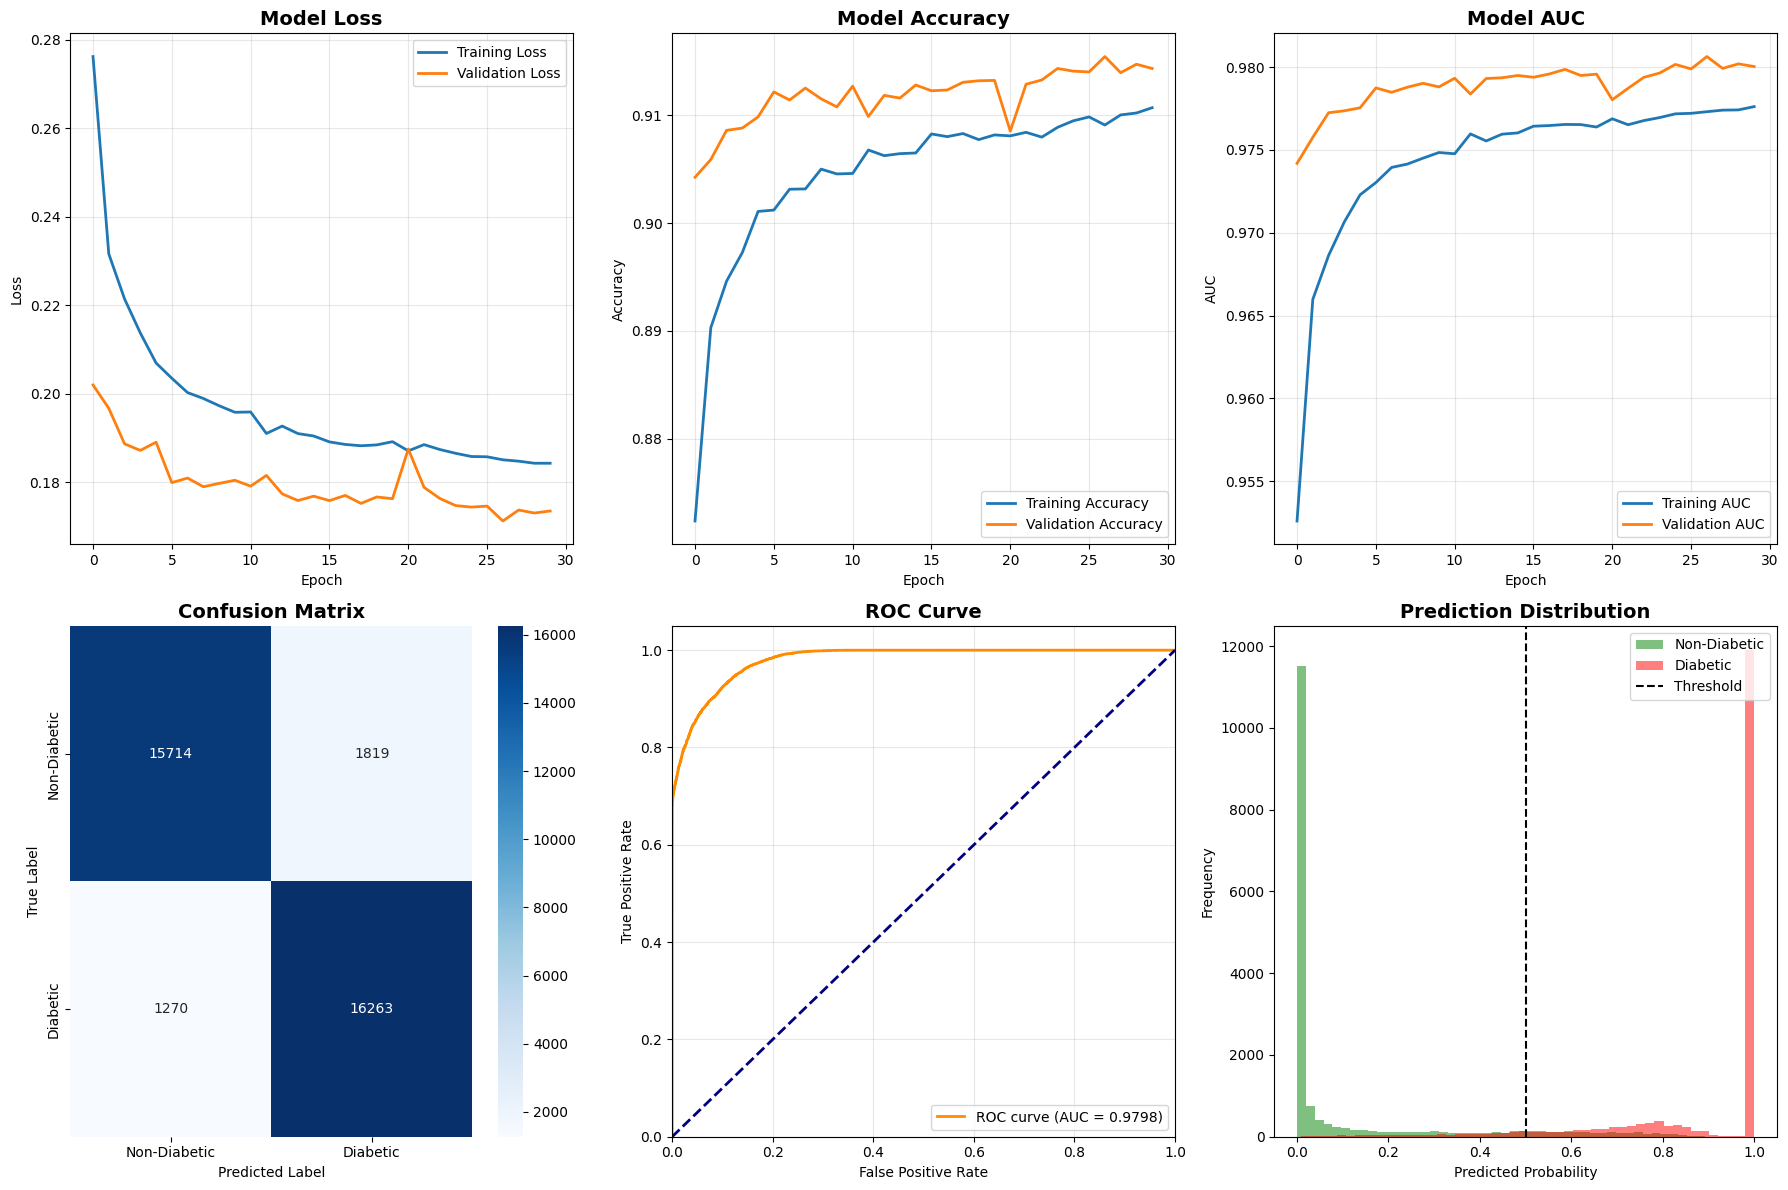

In [13]:

# VISUALIZATION

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training History - Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Training History - Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Training History - AUC
axes[0, 2].plot(history.history['auc'], label='Training AUC', linewidth=2)
axes[0, 2].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
axes[0, 2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('AUC')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# 5. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction Distribution
axes[1, 2].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5,
                label='Non-Diabetic', color='green')
axes[1, 2].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5,
                label='Diabetic', color='red')
axes[1, 2].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[1, 2].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Predicted Probability')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'cnn_model_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

In [14]:

# SAVE FINAL MODEL

# Save model in multiple formats
best_model.save(os.path.join(model_dir, 'diabetes_cnn_final.h5'))
best_model.save(os.path.join(model_dir, 'diabetes_cnn_final.keras'))

# Save model architecture
with open(os.path.join(model_dir, 'model_architecture.json'), 'w') as f:
    f.write(best_model.to_json())

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(model_dir, 'training_history.csv'), index=False)

# Save predictions
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'y_pred_proba': y_pred_proba.flatten()
})
results_df.to_csv(os.path.join(model_dir, 'test_predictions.csv'), index=False)

print("\n" + "="*50)
print("Model Training Complete!")
print("="*50)
print(f"\nAll files saved to: {model_dir}")
print("\nSaved files:")
print("  - best_cnn_model.h5")
print("  - diabetes_cnn_final.h5")
print("  - diabetes_cnn_final.keras")
print("  - model_architecture.json")
print("  - training_history.csv")
print("  - test_predictions.csv")
print("  - cnn_model_performance.png")



Model Training Complete!

All files saved to: /content/drive/MyDrive/DiabetesPrediction/outputs/models

Saved files:
  - best_cnn_model.h5
  - diabetes_cnn_final.h5
  - diabetes_cnn_final.keras
  - model_architecture.json
  - training_history.csv
  - test_predictions.csv
  - cnn_model_performance.png


In [15]:

# INFERENCE FUNCTION

def predict_diabetes(features):
    """
    Make predictions on new data

    Parameters:
    features: array-like, shape (n_samples, 8)
              Features: [gender, age, hypertension, heart_disease,
                        smoking_history, bmi, HbA1c_level, blood_glucose_level]

    Returns:
    predictions: array of probabilities
    """
    # Load scaler and encoder
    scaler = joblib.load(os.path.join(drive_dir, 'scaler.pkl'))

    # Scale features
    features_scaled = scaler.transform(features)

    # Reshape for CNN
    features_cnn = features_scaled.reshape(features_scaled.shape[0],
                                          features_scaled.shape[1], 1)

    # Make predictions
    predictions = best_model.predict(features_cnn)

    return predictions

# Example usage
print("\n" + "="*50)
print("Example Prediction")
print("="*50)

# Example: Female, 45 years old, no hypertension, no heart disease,
# never smoked, BMI 27.5, HbA1c 6.5, blood glucose 140
example_data = np.array([[0, 45, 0, 0, 3, 27.5, 6.5, 140]])
prediction = predict_diabetes(example_data)
print(f"\nPrediction probability: {prediction[0][0]:.4f}")
print(f"Prediction: {'Diabetic' if prediction[0][0] > 0.5 else 'Non-Diabetic'}")


Example Prediction


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step

Prediction probability: 0.2877
Prediction: Non-Diabetic
